# Project 3: Classify Song Lyrics according to Genre

Authors: 
* Andreas Bonny
* Niclas Lensch
* Klaus Luhan

## Goal

The goal of this project is to find out whether it is possible to predict the genre of a song based on its lyrics. To
this end, devise one or multiple approaches based on the methods discussed in the lecture and evaluate how
well they perform.


# Prerequisite

## Download nltk

Since we analyse lyrics which are written in human language, this work makes heavy use of the Natural Language Toolkit, the leading platform to work with human language Data. To use NLTK the needed ressource files have to be downloaded by using the
>nltk.download()

command. It enables us to easily use data analyzing methods such as tokenization or stemming.

In [ ]:
import nltk

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Checking for GPU

*This section can be ignored if there is no valid GPU set up*

Because the Project is performance heavy, we recommend the usage of GPU and CPU to improve , if there is a GPU available but not set up, we recommend adding it to your python-environment. Furthermore to use the GPU the Cuda Framework needs to be installed. It is very important to watch out the Version of cuda it **needs** to match with the tensorflow version installed.

In [36]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

print("There is", len(gpus), "detected GPU")
print("There is", len(cpus), "detected CPU")

There is 1 detected GPU
There is 1 detected CPU


Additionally it is recommended to enable dynamic memory growth for the GPU. If not available the GPU will reserve all video memory, which can lead to System instabilities.

In [ ]:
# https://medium.com/@starriet87/tensorflow-2-0-wanna-limit-gpu-memory-10ad474e2528
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Prepare Data for preprocessing

Before we can use the data we need to prepare and preprocess it. After that the subset of the original dataset can be used in neural networks and the like.

First the two csv files *artists-data.csv* and *lyrics-data.csv*  are loaded into the corresponding pandas dataframes as shown below. Thereafter the dataframes are joined together and saved into  raw_df to get one dataframe with the entire required data, which can be seen in the following code segment. Additionally the identifiers are transformed into lowercase, to enable a convenient use. After all this is done the dataframe raw_df contains {{ len(raw_df)}} loaded datasets.

## Load form Disk and join

In [5]:
import pandas as pd

song_df = pd.read_csv('./song-lyrics/lyrics-data.csv')
author_df = pd.read_csv('./song-lyrics/artists-data.csv')

song_df = song_df.rename(columns={'ALink': 'Link'})

raw_df = song_df.merge(author_df, on='Link') 
raw_df.columns = raw_df.columns.str.lower()

print("There are", len(raw_df), "datasets loaded")

There are 227513 datasets loaded


## Remove unneeded data

Now that our ~227000 datasets are loaded the unneeded Data must be removed to ensure a better performance and more accurate results.
First every column which is not needed to categorize the lyrics to a genre is dropped.
Thereafter every lyric which is not in English gets removed, since the task is to only categorize english songs.
At last every duplicate song is removed to ensure a clear dataset.
These two steps reduce the data to {{Test}} datasets.

In [6]:
import pandas as pd

columns_to_drop = ['slink','link', 'popularity', 'genres', 'songs', 'link', 'idiom']

filterd_df = raw_df[raw_df.idiom.eq('ENGLISH')]
filterd_df = filterd_df.drop_duplicates(subset='slink', keep='first') 
filterd_df = filterd_df.drop(columns_to_drop, axis=1)

# General preprocessing

After the cleanup of the overall data, the lyrics are now further processed. First of all, before the more complex processings, all lyrics are transformed into lower case to enable a consistent use. After that the two techniques tokenization and lemmatization are used in the general preprocessing. Each of them using NLTK and separated into its own code block. Furthermore after these two methods are done, the data is cleaned up to, agaian, enable a convenient use.

In [7]:
import pandas as pd

transformed_df = filterd_df

## Lowercase

In [8]:
import pandas as pd

transformed_df['lyric'] = transformed_df['lyric'].str.lower()

## Tokenize

The first big step in the preprocessing is the tokenization, which consists of two parts. The first part is transforming every lyric into verses. The second part transforms the resulting verses into word-level-tokens. The result of the tokenization is a datastream with a list of verses, which in turn contains a list of words. This possibly enables more variation of data that can be used in the learning process.

In [ ]:
import nltk

def lyric_to_verse(lyric):
    return nltk.sent_tokenize(lyric,language='english')

def verse_to_word(verse):
    return nltk.word_tokenize(verse, language='english')

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: lyric_to_verse(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: [verse_to_word(verse) for verse in x])

## Lemmatize

The second method of preprocess is the lemmatization. The process consists of stemming and then the actual lemmatization. The stemming leads back a single word to its word stem. Thereafter the stemmed word gets categorized into the word class it has. To simplify this, since a completely detailed lemmatization is not needed, the word classes get mapped to the basic classes of adjective, noun, adverb and verb. After this the data is returned and the only step left is to clean it up.

In [10]:
import nltk
from nltk.corpus import wordnet


#by http://textmining.wp.hs-hannover.de/Preprocessing.html
def pos_tagger(sentences):
    return [nltk.pos_tag(sent) for sent in sentences]

def wntag(pttag):
    if pttag in ['JJ', 'JJR', 'JJS']:
        return wordnet.ADJ
    elif pttag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wordnet.NOUN
    elif pttag in ['RB', 'RBR', 'RBS']:
        return wordnet.ADV
    elif pttag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wordnet.VERB
    return None

def lemmatize(lemmatizer,word,pos):
    if pos == None:
        return word
    else:
        return lemmatizer.lemmatize(word,pos)
    
def lem(sentences):
    transformed = []
    for sentence in sentences:
        transformed.append([lemmatize(lemmatizer,word,wntag(pos)) for (word,pos) in sentence])
    return transformed 

lemmatizer = nltk.WordNetLemmatizer()

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: pos_tagger(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: lem(x)) 

## Cleanup

In the last part of the lemmatization the resulting data of the first two segments are cleaned up. We remove any artifacts that survived the lemmatization such as empty words, single letter words and all non alphabetic characters. The second part of the Cleanup is to remove stopwords. To do that gensim is used in order to gain a preexisting list while also adding a few other stopwords. As a result of this partial step, we gain an object that contains the lyrics without the found stopwords in vers-level-tokens. 

In [19]:
import re
import nltk
from nltk.corpus import stopwords

def clean_non_alphabetic_characters(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(map(lambda x: re.sub("[\W_]", '', x), sentence)))
    return cleaned

def clean_empty_words(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda x: x != '' and x != "", sentence)))
    return cleaned

def clean_single_letters(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda x: len(x) != 1, sentence)))
    return cleaned

def clean_empty_sentences(sentences):
    return list(filter(lambda x : len(x) != 0, sentences))

def remove_stopwords(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda word: not word in sw, sentence)))
    return cleaned


# Serius performace issius if not cached
sw = stopwords.words()
    
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_non_alphabetic_characters(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_empty_words(x))  
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_single_letters(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_empty_sentences(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: remove_stopwords(x)) 

# Store preproccesed data

In further steps, it is needed to directly access the processed data. Since it is not efficient to preprocess the data with each execution, it gets saved as a new file that contains the processed data.

## Save to disk

In [21]:
transformed_df.to_csv (r'./export_dataframe.csv', index = False, header=True)

# Optional preprocessing

In this step we flatten our data.

BUG: wenn man es das erste mal ausfrührt muss man eine zeile im helper auskommentieren die probiert die später erstellte datei zu erstellen, rennen hier etwas in ein henne ei problem

In [22]:
from helper import get_fresh_flatted_copy

transformed_opt_df = get_fresh_flatted_copy(1)

## Remove lyrics that are too long
We checked, whether or not removing songs that are too long increases our accuracy. However, it was not possible to properly separate long lyrics from "regular" lyrics. As such, this step did not bear great results.

In [23]:
import pandas as pd

def identifyLongLyrics(data_df, capsize = 1500):
    data_df['size'] = data_df['lyric'].transform(lambda x: len(x))  
    data_df = data_df.query('size <= ' + str(capsize))
    return data_df
    
    
def identifyShortLyrics(data_df, minSize = 10):
    data_df['size'] = data_df['lyric'].transform(lambda x: len(x))  
    data_df = data_df.query('size >= ' + str(minSize))
    return data_df

transformed_opt_df = identifyLongLyrics(transformed_opt_df)
transformed_opt_df = identifyShortLyrics(transformed_opt_df)

## Remove additional genres

While analyizing our data, we observed that after removing all non-english songs, there are genres that contain almost no songs and therefore are unnecessary for the predictions. Thus, we removed all genres that contain less songs than a given threshhold (default value was 100)

In [24]:
import pandas as pd

def filterSmallGenres(data, level='lyric',threshold = 100):
    genres = data.genre.unique()

    df_container = {}

    for genre in genres:
        df_container[genre] = data[data.genre.eq(genre)]
    
    for key in list(df_container.keys()):
        if(len(df_container[key]) < threshold):
            del df_container[key]

    return pd.concat(df_container.values())

transformed_opt_df = filterSmallGenres(transformed_opt_df)

## Normalize dataset

Normilization is a common way of preprocessing data and therefore is also used here.

In [25]:
def normalizeData(data, level='lyric'):
    genres = data.genre.unique()

    df_container = {}

    #Baue einen dict anhand der existierenden genres
    for genre in genres:
        df_container[genre] = data[data.genre.eq(genre)]
    
    sampleSize = 0
    
    #Finde heraus welches genre die wenigsten lieder enthält
    for key in list(df_container.keys()):
        if(sampleSize == 0):
            sampleSize = len(df_container[key])
        else:
            if(len(df_container[key]) < sampleSize):
                sampleSize = len(df_container[key])
            
    #Pick mir einen Sample anhand des wertes sampleSize
    for key in list(df_container.keys()):
        df_container[key] = df_container[key].sample(n = sampleSize);
    
    return pd.concat(df_container.values())
    
transformed_opt_df = normalizeData(transformed_opt_df)

# Store optional preprocessed data

The optionally preprocessed data is again saved in another file for easier access. In the following steps, there is always the option to either use the general preprocessed data or to use the optional data.

In [26]:
transformed_opt_df.to_csv (r'./export_dataframe_opt.csv', index = False, header=True)

# Look at the data
Before we use neural networks and machine learning algorithms zu analyze our data, we want to give a general overview of our now preprocessed data. We take a look at the genre and frequency distribution of our data as well as other information.

## Genre distribution

First we will look at the distribution of generes in our dataset

<AxesSubplot:xlabel='genre', ylabel='count'>

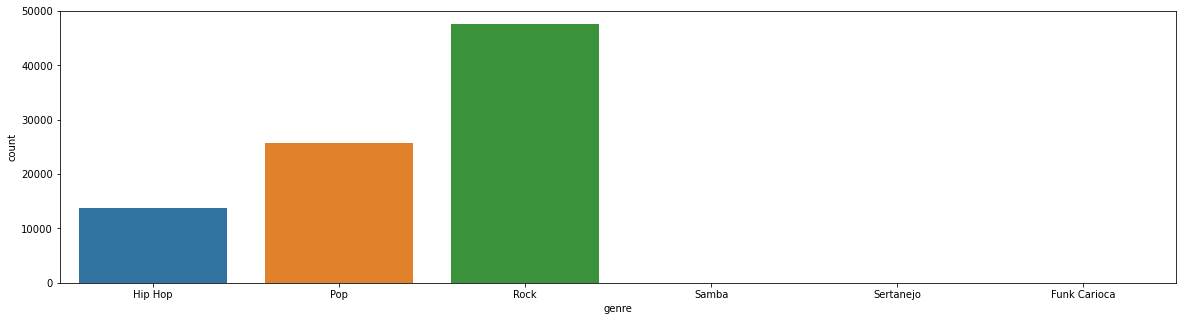

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

from helper import get_fresh_copy

plt.figure(figsize=(20, 5))
sns.countplot(data=get_fresh_copy(), x='genre')

## Frequency distribution

We also want to display a frequency distribution of the most common words in our dataset. We also take a look at the distribution of stopwords of different genres

In [28]:
import itertools
import nltk
import pandas as pd

def lengthDistribution(data_df):
    genres = data_df.genre.unique()

    lengthDistribution
    df_container = {}
    fd_container = {}

    total_word_count = {}

    merged_fd_df = pd.DataFrame(data = nltk.FreqDist(itertools.chain.from_iterable(data_df['lyric'])).items(), columns=['words', 'frequency'])
    merged_fd_df = merged_fd_df.sort_values("frequency", ascending=False)

    for genre in genres:
        df_container[genre] = data_df[data_df.genre.eq(genre)]
        fd_container[genre] = nltk.FreqDist(itertools.chain.from_iterable(df_container[genre]['lyric']))
        total_word_count[genre] = sum(fd_container[genre].values())
        fd_container[genre] = pd.DataFrame(fd_container[genre].items(), columns=['words', genre])
        fd_container[genre][genre] = fd_container[genre][genre].transform(lambda x: x/total_word_count[genre]) 
        merged_fd_df = merged_fd_df.merge(fd_container[genre], on='words')

    merged_fd_df = merged_fd_df.drop(['frequency'], axis=1)
    merged_fd_df = merged_fd_df.set_index('words')
    
    return merged_fd_df

### General preprocessed dataset

<AxesSubplot:xlabel='words'>

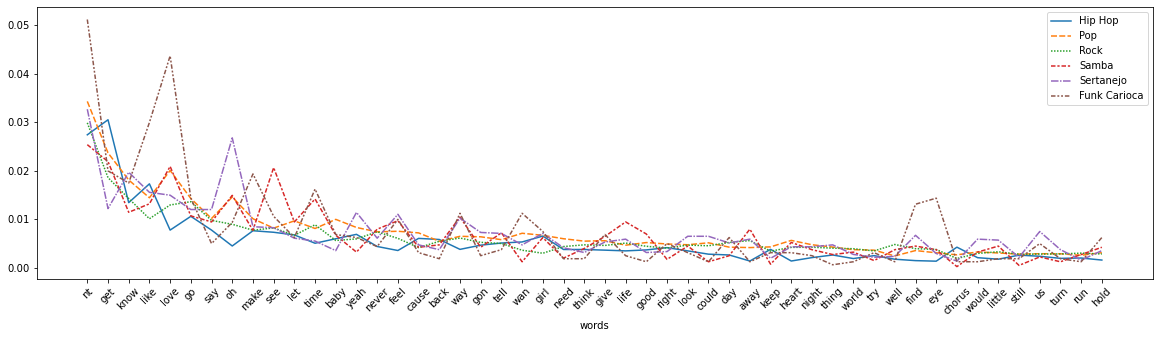

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from helper import get_fresh_flatted_copy

        
length_distribution_df = lengthDistribution(get_fresh_flatted_copy(1))

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)    
sns.lineplot(data=length_distribution_df.head(50))

### Optional preprocessed dataset

<AxesSubplot:xlabel='words'>

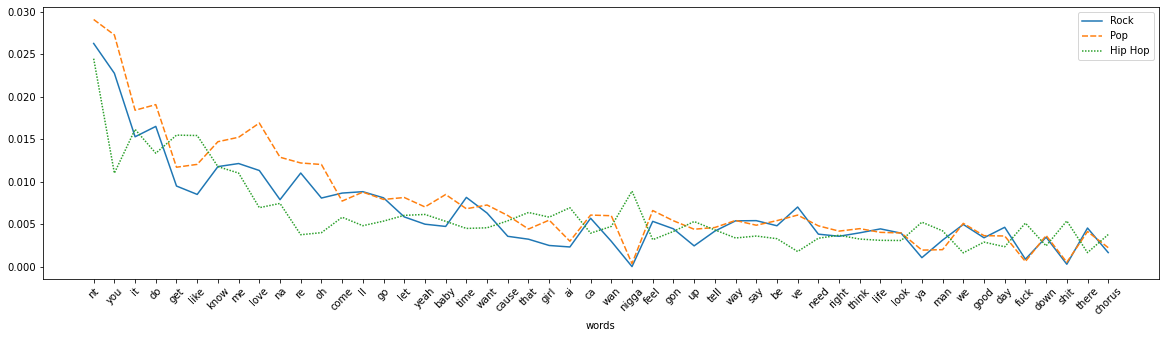

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from helper import get_fresh_copy

        
length_distribution_df = lengthDistribution(get_fresh_copy(opt=True))

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)    
sns.lineplot(data=length_distribution_df.head(50))

## Distribution of lyric length by genre (word based)

We take a look whether some genres are more likely to have longer lyrics than others.

In [31]:
import pickle

def freqenzyDistribution(data, level='lyric'):
    data[level] = data[level].transform(lambda x: len(x))

    genres = data.genre.unique()

    df_container = {}
    mean_container = {}
    std_container = {}
    counts_container = {}

    for genre in genres:
        df_container[genre] = pickle.loads(pickle.dumps(data[data.genre.eq(genre)]))

    for genre in genres:
        mean_container[genre] = df_container[genre][level].values.mean()

    for genre in genres:
        std_container[genre] = df_container[genre][level].values.std()

    for genre in genres:
        counts_container[genre] = df_container[genre][level].value_counts(normalize=True)

    for genre in genres:
        counts_container[genre] = pd.DataFrame.from_dict(counts_container[genre])
        counts_container[genre]['genre'] = genre
        counts_container[genre] = counts_container[genre].reset_index()
        counts_container[genre] = counts_container[genre].rename(columns={level: 'count'})
        counts_container[genre] = counts_container[genre].rename(columns={'index': 'length'})

    return pd.concat(counts_container.values())

### General preprocessed dataset

<AxesSubplot:xlabel='length', ylabel='count'>

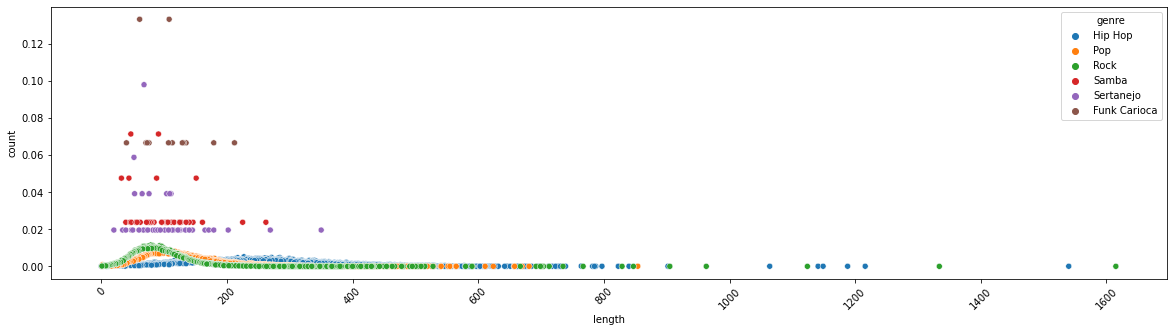

In [32]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_flatted_copy
    
        
flatted_df = get_fresh_flatted_copy(1)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.scatterplot(data=result_df, x="length", y="count", hue="genre")

### Optional preprocessed dataset
If we take a look at only our three main genres, Rock, Pop and Hip Hop, we see, that generally Rock songs are the shortest of all of them. Most Rock songs are less than 200 words long (after removing stopwords) while Hip Hop contains the longest songs, some of which contain more than 600 words.

<AxesSubplot:xlabel='length', ylabel='count'>

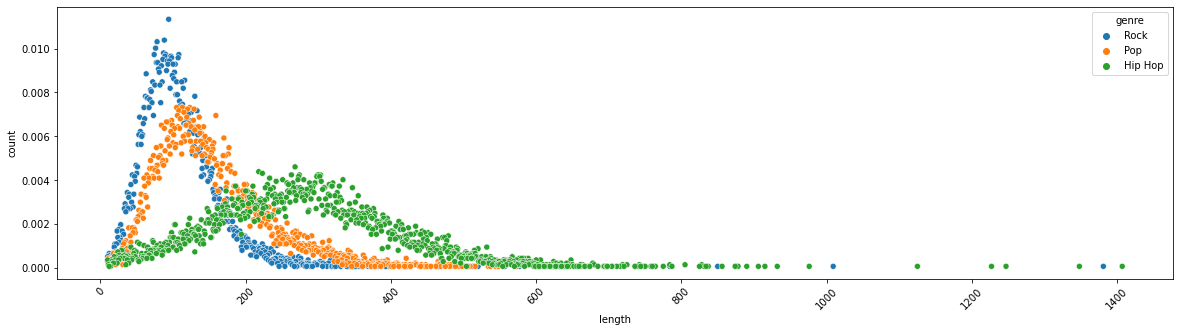

In [33]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_flatted_copy
    
        
flatted_df = get_fresh_copy(opt=True)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.scatterplot(data=result_df, x="length", y="count", hue="genre")

## Distribution of lyric length by genre (verse based)

We take another look at the distibution of lyric length, this time, the length is based on a whole verse instead of words. Our result is that most songs consist of less than 8 verses while Hip Hop lyrics are generally longer than other genres which confirms the word based distribution in which Hip Hop also is generally longer than Rock or Pop. 

<AxesSubplot:xlabel='length', ylabel='count'>

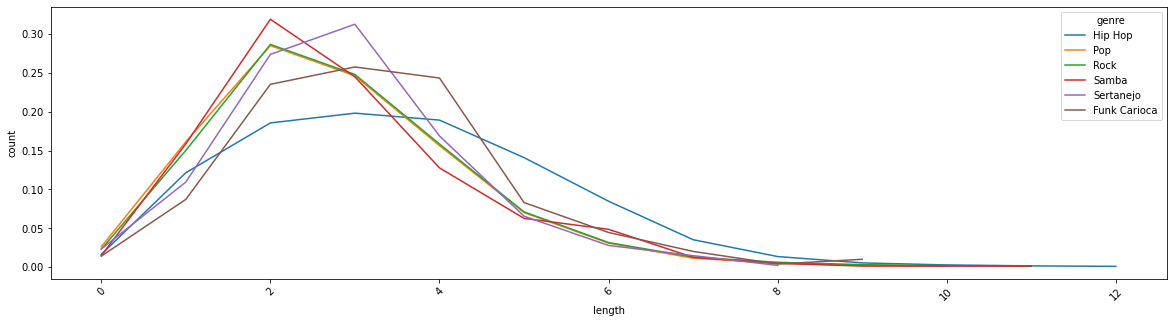

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_copy, melt

flatted_df = get_fresh_copy(1)
flatted_df = pd.DataFrame(melt(flatted_df))

result_df = freqenzyDistribution(flatted_df, 'verse')

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.lineplot(data=result_df[result_df['count']>= 0.001], x="length", y="count", hue="genre")

## Distribution of lyric length by genre (lyrics/verse based)

we look if some generes as more likly to have shorter or longer lyrics

<AxesSubplot:xlabel='length', ylabel='count'>

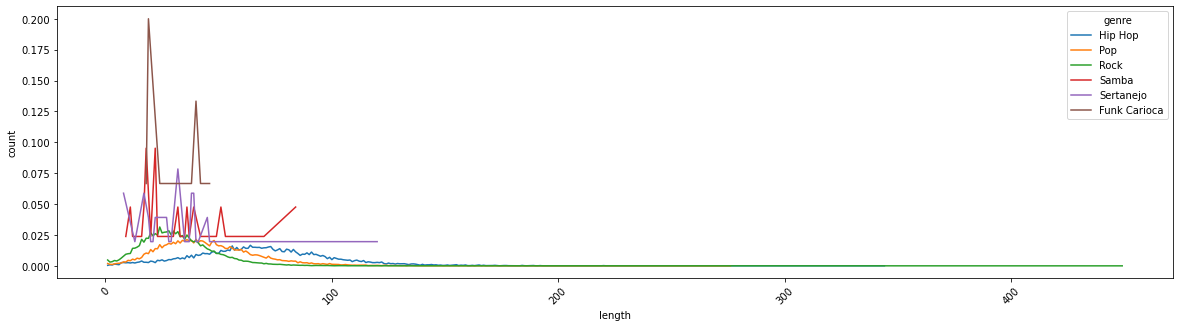

In [35]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from helper import get_fresh_copy

flatted_df = get_fresh_copy(1)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.lineplot(data=result_df, x="length", y="count", hue="genre")

# Learning

## Baselines

In [ ]:
#TODO: MOVE to ende

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent", random_state=10)
dummy.fit(g_x_train, g_y_train)
most_frequent_score = dummy.score(g_x_test, g_y_test)
print("Baseline by always choosing the most frequent label: ", most_frequent_score) # always predicts most frequent label

dummy = DummyClassifier(strategy="uniform", random_state=10)
dummy.fit(g_x_train, g_y_train)
uniform_score = dummy.score(g_x_test, g_y_test)
print("Baseline by always predicting label at random: ", uniform_score) # random prediction

dummy = DummyClassifier(strategy="stratified", random_state=10, constant="rock")
dummy.fit(g_x_train, g_y_train)
stratified_score = dummy.score(g_x_test, g_y_test)
print("Baseline by respecting the training sets class distribution: ", stratified_score) # prediction by respecting the training sets class distribution

## Simple Neural Networks

In [1]:
# Move to Helper
#https://stackoverflow.com/questions/42406233/how-to-add-title-to-seaborn-boxplot
def print_graph(history_a, history_b):
    history_df = pd.DataFrame(history_a.history)

    plt.figure(figsize=(20, 5))
    plt.xticks(rotation=45)
    sns.lineplot(data=history_df).set_title('General Data')

    history_df = pd.DataFrame(history_b.history)

    plt.figure(figsize=(20, 5))
    plt.xticks(rotation=45)
    sns.lineplot(data=history_df).set_title("Optional Data")

### Prepare Data

In [ ]:
import keras
from keras.preprocessing.text import Tokenizer

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from helper import get_fresh_flatted_copy, get_fresh_copy

def prepData(data_df):
    preprocessed_df = data_df

    x_train, x_test, y_train, y_test = train_test_split(preprocessed_df['lyric'], preprocessed_df['genre'], test_size=0.20)
    tokenizer = Tokenizer(num_words=10000)

    le = preprocessing.LabelEncoder()
    le.fit(y_train)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)

    num_classes =  len(preprocessed_df['genre'].unique())
    tokenizer.fit_on_texts(x_train)

    x_train = tokenizer.texts_to_matrix(x_train, mode='tfidf')
    x_test = tokenizer.texts_to_matrix(x_test, mode='tfidf')

    y_train = keras.utils.to_categorical(y_train)
    y_test = keras.utils.to_categorical(y_test)
    
    return x_train, x_test, y_train, y_test, num_classes

g_x_train, g_x_test, g_y_train, g_y_test, g_num_classes = prepData(get_fresh_flatted_copy())
o_x_train, o_x_test, o_y_train, o_y_test, o_num_classes = prepData(get_fresh_copy(opt=1))

## Baselines

In [6]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent", random_state=10)
dummy.fit(g_x_train, g_y_train)
most_frequent_score = dummy.score(g_x_test, g_y_test)
print("Baseline by always choosing the most frequent label: ", most_frequent_score) # always predicts most frequent label

dummy = DummyClassifier(strategy="uniform", random_state=10)
dummy.fit(g_x_train, g_y_train)
uniform_score = dummy.score(g_x_test, g_y_test)
print("Baseline by always predicting label at random: ", uniform_score) # random prediction

dummy = DummyClassifier(strategy="stratified", random_state=10, constant="rock")
dummy.fit(g_x_train, g_y_train)
stratified_score = dummy.score(g_x_test, g_y_test)
print("Baseline by respecting the training sets class distribution: ", stratified_score) # prediction by respecting the training sets class distribution

Baseline by always choosing the most frequent label:  0.554127703516723
Baseline by always predicting label at random:  0.014514370948310481
Baseline by respecting the training sets class distribution:  0.2229935172967701


### Shallow Neural Network

#### General Data

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(g_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 100

history_g = model.fit(g_x_train, g_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_g_dict = history_g.history
acc_g = history_g_dict['accuracy']
vacc_g = history_g_dict['val_accuracy']
loss_g = history_g_dict['loss']
vloss_g = history_g_dict['val_loss']


score_g = model.evaluate(g_x_test, g_y_test, batch_size=batch_size, verbose=1)

Epoch 1/100
1961/1961 [==============================] - 4s 2ms/step - loss: 0.6995 - accuracy: 0.7099 - val_loss: 0.5876 - val_accuracy: 0.7565
Epoch 2/100
1961/1961 [==============================] - 3s 2ms/step - loss: 0.5532 - accuracy: 0.7683 - val_loss: 0.5859 - val_accuracy: 0.7536
Epoch 3/100
1961/1961 [==============================] - 3s 2ms/step - loss: 0.4843 - accuracy: 0.7965 - val_loss: 0.6019 - val_accuracy: 0.7552
Epoch 4/100
1961/1961 [==============================] - 3s 2ms/step - loss: 0.4359 - accuracy: 0.8208 - val_loss: 0.6348 - val_accuracy: 0.7556
Epoch 5/100
1961/1961 [==============================] - 3s 2ms/step - loss: 0.3953 - accuracy: 0.8375 - val_loss: 0.6666 - val_accuracy: 0.7501
Epoch 6/100
1961/1961 [==============================] - 3s 2ms/step - loss: 0.3602 - accuracy: 0.8548 - val_loss: 0.7185 - val_accuracy: 0.7532
Epoch 7/100
1961/1961 [==============================] - 3s 2ms/step - loss: 0.3331 - accuracy: 0.8657 - val_loss: 0.7688 - val_ac

#### Optional Data

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 100

history_o = model.fit(o_x_train, o_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_o_dict = history_o.history
acc_o = history_o_dict['accuracy']
vacc_o = history_o_dict['val_accuracy']
loss_o = history_o_dict['loss']
vloss_o = history_o_dict['val_loss']

score_o = model.evaluate(o_x_test, o_y_test, batch_size=batch_size, verbose=1)

Epoch 1/100
923/923 [==============================] - 2s 2ms/step - loss: 0.7161 - accuracy: 0.6753 - val_loss: 0.6024 - val_accuracy: 0.7277
Epoch 2/100
923/923 [==============================] - 2s 2ms/step - loss: 0.5288 - accuracy: 0.7738 - val_loss: 0.6097 - val_accuracy: 0.7274
Epoch 3/100
923/923 [==============================] - 2s 2ms/step - loss: 0.4251 - accuracy: 0.8235 - val_loss: 0.6604 - val_accuracy: 0.7247
Epoch 4/100
923/923 [==============================] - 2s 2ms/step - loss: 0.3516 - accuracy: 0.8583 - val_loss: 0.7476 - val_accuracy: 0.7204
Epoch 5/100
923/923 [==============================] - 2s 2ms/step - loss: 0.2983 - accuracy: 0.8823 - val_loss: 0.8117 - val_accuracy: 0.7162
Epoch 6/100
923/923 [==============================] - 2s 2ms/step - loss: 0.2626 - accuracy: 0.8987 - val_loss: 0.8937 - val_accuracy: 0.7128
Epoch 7/100
923/923 [==============================] - 2s 2ms/step - loss: 0.2345 - accuracy: 0.9090 - val_loss: 0.9749 - val_accuracy: 0.7101

#### Results

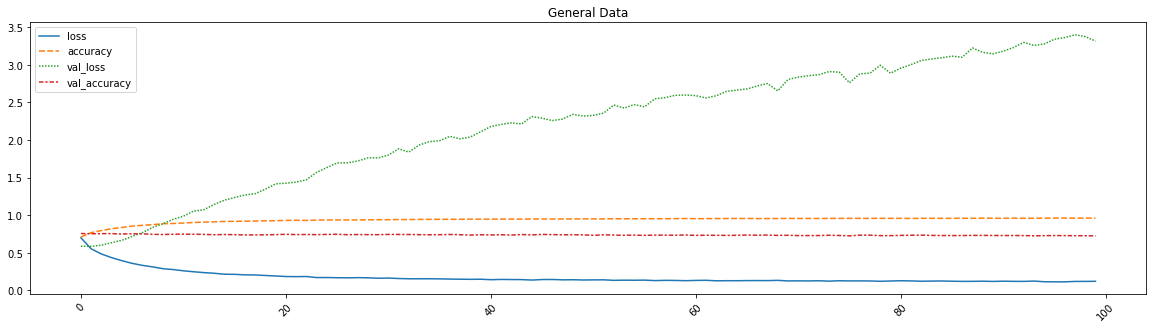

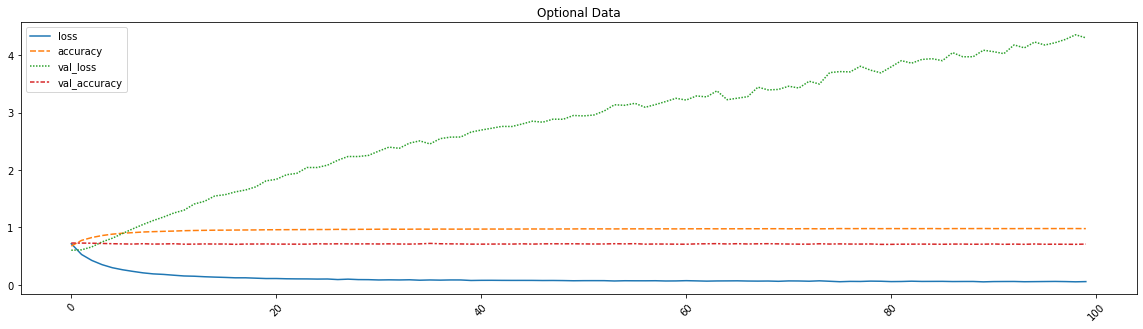

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_graph(history_g, history_o)

### Deep Dense Neural Network

#### General Data

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(g_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 100

history_g = model.fit(g_x_train, g_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_g_dict_deep = history_g.history
acc_g_deep = history_g_dict_deep['accuracy']
vacc_g_deep = history_g_dict_deep['val_accuracy']
loss_g_deep = history_g_dict_deep['loss']
vloss_g_deep = history_g_dict_deep['val_loss']

score_g_deep = model.evaluate(g_x_test, g_y_test, batch_size=batch_size, verbose=1)

Epoch 1/100
1961/1961 [==============================] - 4s 2ms/step - loss: 0.7380 - accuracy: 0.6793 - val_loss: 0.6531 - val_accuracy: 0.7027
Epoch 2/100
1961/1961 [==============================] - 4s 2ms/step - loss: 0.6117 - accuracy: 0.7421 - val_loss: 0.6145 - val_accuracy: 0.7301
Epoch 3/100
1961/1961 [==============================] - 4s 2ms/step - loss: 0.5545 - accuracy: 0.7729 - val_loss: 0.5962 - val_accuracy: 0.7430
Epoch 4/100
1961/1961 [==============================] - 4s 2ms/step - loss: 0.5067 - accuracy: 0.7977 - val_loss: 0.6162 - val_accuracy: 0.7398
Epoch 5/100
1961/1961 [==============================] - 4s 2ms/step - loss: 0.4690 - accuracy: 0.8158 - val_loss: 0.6208 - val_accuracy: 0.7500
Epoch 6/100
1961/1961 [==============================] - 4s 2ms/step - loss: 0.4339 - accuracy: 0.8341 - val_loss: 0.6307 - val_accuracy: 0.7497
Epoch 7/100
1961/1961 [==============================] - 4s 2ms/step - loss: 0.4004 - accuracy: 0.8483 - val_loss: 0.6610 - val_ac

#### Optional Data

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 100

history_o = model.fit(o_x_train, o_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_o_dict_deep = history_o.history
acc_o_deep = history_o_dict_deep['accuracy']
vacc_o_deep = history_o_dict_deep['val_accuracy']
loss_o_deep = history_o_dict_deep['loss']
vloss_o_deep = history_o_dict_deep['val_loss']

score_o = model.evaluate(o_x_test, o_y_test, batch_size=batch_size, verbose=1)

Epoch 1/100
923/923 [==============================] - 2s 2ms/step - loss: 0.7844 - accuracy: 0.6173 - val_loss: 0.6878 - val_accuracy: 0.6787
Epoch 2/100
923/923 [==============================] - 2s 2ms/step - loss: 0.6444 - accuracy: 0.7139 - val_loss: 0.6220 - val_accuracy: 0.7101
Epoch 3/100
923/923 [==============================] - 2s 2ms/step - loss: 0.5568 - accuracy: 0.7611 - val_loss: 0.6087 - val_accuracy: 0.7223
Epoch 4/100
923/923 [==============================] - 2s 2ms/step - loss: 0.4883 - accuracy: 0.7991 - val_loss: 0.6320 - val_accuracy: 0.7235
Epoch 5/100
923/923 [==============================] - 2s 2ms/step - loss: 0.4295 - accuracy: 0.8272 - val_loss: 0.6441 - val_accuracy: 0.7159
Epoch 6/100
923/923 [==============================] - 2s 2ms/step - loss: 0.3808 - accuracy: 0.8494 - val_loss: 0.6769 - val_accuracy: 0.7235
Epoch 7/100
923/923 [==============================] - 3s 4ms/step - loss: 0.3491 - accuracy: 0.8664 - val_loss: 0.7314 - val_accuracy: 0.7168

#### Results

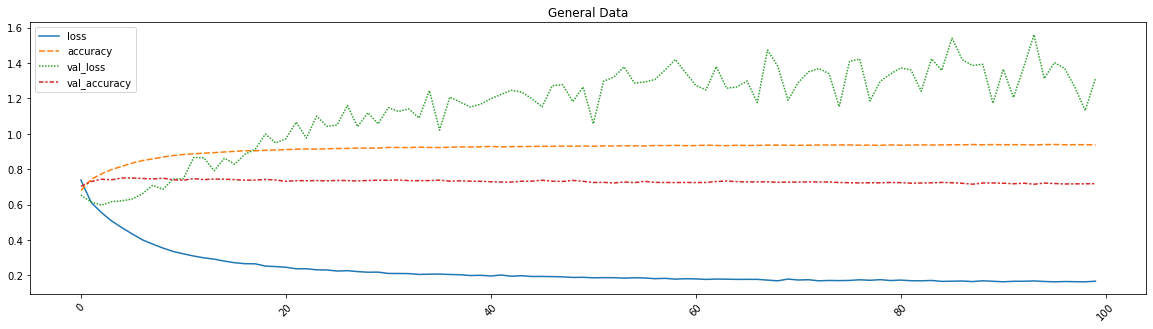

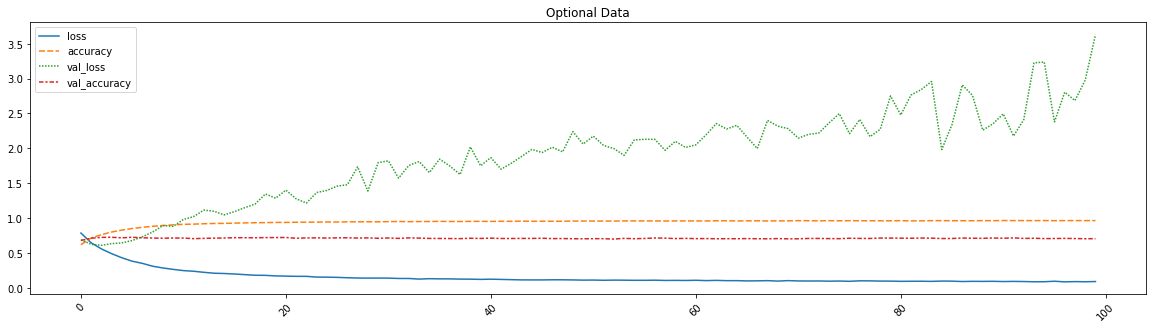

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_graph(history_g, history_o)

### Big Deep Dense Neural Network

#### General Data

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(1024, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2084))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024))
model.add(Dense(g_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 100

history_g = model.fit(g_x_train, g_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_g_dict_bigdeep = history_g.history
acc_g_bigdeep = history_g_dict_bigdeep['accuracy']
vacc_g_bigdeep = history_g_dict_bigdeep['val_accuracy']
loss_g_bigdeep = history_g_dict_bigdeep['loss']
vloss_g_bigdeep = history_g_dict_bigdeep['val_loss']

score_g = model.evaluate(g_x_test, g_y_test, batch_size=batch_size, verbose=1)

Epoch 1/100
1961/1961 [==============================] - 11s 6ms/step - loss: 0.7386 - accuracy: 0.7005 - val_loss: 0.6433 - val_accuracy: 0.7308
Epoch 2/100
1961/1961 [==============================] - 11s 5ms/step - loss: 0.6162 - accuracy: 0.7608 - val_loss: 0.6954 - val_accuracy: 0.7189
Epoch 3/100
1961/1961 [==============================] - 11s 5ms/step - loss: 0.5242 - accuracy: 0.8066 - val_loss: 0.7893 - val_accuracy: 0.6978
Epoch 4/100
1961/1961 [==============================] - 11s 5ms/step - loss: 0.4636 - accuracy: 0.8424 - val_loss: 1.0071 - val_accuracy: 0.6900
Epoch 5/100
1961/1961 [==============================] - 11s 5ms/step - loss: 0.4266 - accuracy: 0.8673 - val_loss: 0.9867 - val_accuracy: 0.7334
Epoch 6/100
1961/1961 [==============================] - 11s 5ms/step - loss: 0.3660 - accuracy: 0.8883 - val_loss: 1.4412 - val_accuracy: 0.7134
Epoch 7/100
1961/1961 [==============================] - 11s 5ms/step - loss: 0.3453 - accuracy: 0.9007 - val_loss: 1.3932 -

#### Optional Data

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(64, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 100

history_o = model.fit(o_x_train, o_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_o_dict_bigdeep = history_o.history
acc_o_bigdeep = history_o_dict_bigdeep['accuracy']
vacc_o_bigdeep = history_o_dict_bigdeep['val_accuracy']
loss_o_bigdeep = history_o_dict_bigdeep['loss']
vloss_o_bigdeep = history_o_dict_bigdeep['val_loss']

score_o = model.evaluate(o_x_test, o_y_test, batch_size=batch_size, verbose=1)

Epoch 1/100
923/923 [==============================] - 2s 2ms/step - loss: 0.7876 - accuracy: 0.6112 - val_loss: 0.6737 - val_accuracy: 0.6896
Epoch 2/100
923/923 [==============================] - 2s 2ms/step - loss: 0.6491 - accuracy: 0.7089 - val_loss: 0.6466 - val_accuracy: 0.7107
Epoch 3/100
923/923 [==============================] - 2s 2ms/step - loss: 0.5636 - accuracy: 0.7558 - val_loss: 0.6646 - val_accuracy: 0.7146
Epoch 4/100
923/923 [==============================] - 2s 2ms/step - loss: 0.4889 - accuracy: 0.7957 - val_loss: 0.6738 - val_accuracy: 0.7110
Epoch 5/100
923/923 [==============================] - 2s 2ms/step - loss: 0.4374 - accuracy: 0.8249 - val_loss: 0.7179 - val_accuracy: 0.7171
Epoch 6/100
923/923 [==============================] - 2s 2ms/step - loss: 0.3879 - accuracy: 0.8492 - val_loss: 0.7715 - val_accuracy: 0.7061
Epoch 7/100
923/923 [==============================] - 2s 2ms/step - loss: 0.3539 - accuracy: 0.8633 - val_loss: 0.8418 - val_accuracy: 0.7143

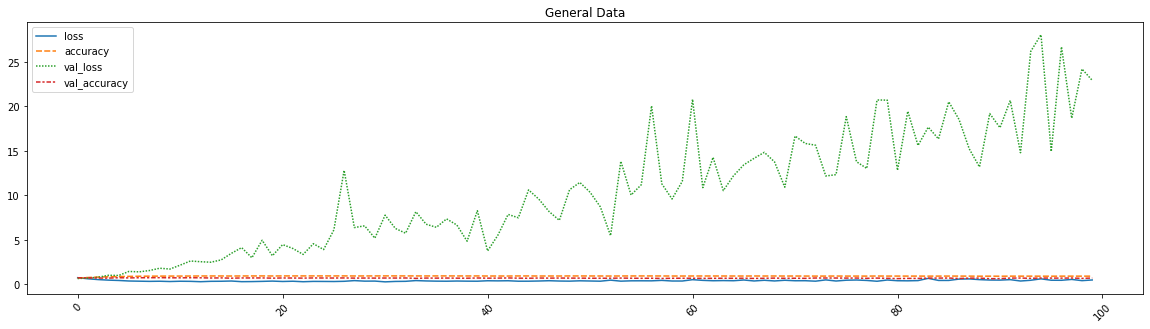

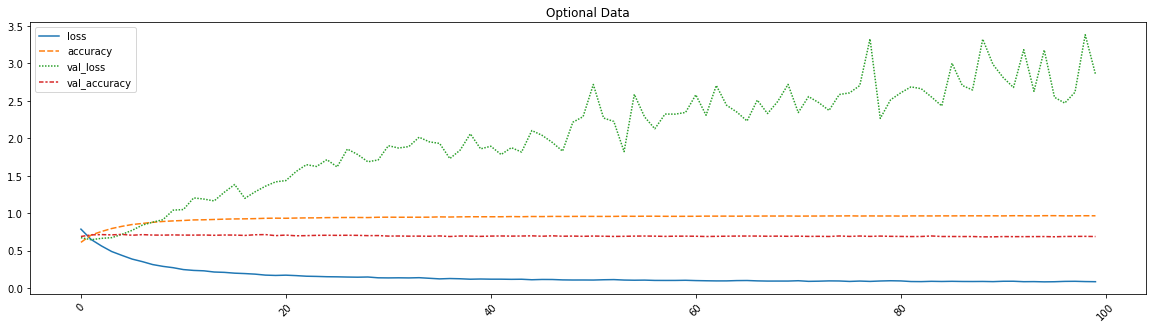

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_graph(history_g, history_o)

### Verso

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

model = Sequential()
model.add(Dense(2048, input_shape=(10000, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2048))
model.add(Dense(o_num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 5

history_v = model.fit(v_x_train, v_y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history_v_dict_bigdeep = history_v.history
acc_v_bigdeep = history_v_dict_bigdeep['accuracy']
vacc_v_bigdeep = history_v_dict_bigdeep['val_accuracy']
loss_v_bigdeep = history_v_dict_bigdeep['loss']
vloss_v_bigdeep = history_v_dict_bigdeep['val_loss']

score_o = model.evaluate(v_x_test, v_y_test, batch_size=batch_size, verbose=1)

NameError: name 'v_x_train' is not defined

In [ ]:
import pandas as pd
songs_df = get_fresh_copy(0.1)
songs_df['pred'] = songs_df['lyric'].transform(lambda x: pd.DataFrame(data=model.predict_classes(x, verbose=1), column=['verse_pred'])


wrong = 0
right = 0

songs_df['pred'] = songs_df['pred'].value_counts().idxmax()

## Complex Neural Networks

In [8]:
MAX_SEQUENCE_LENGTH = 400
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

### Prepare Data

load data and factorize 'genre'

#### Load Data

In [9]:
import pandas as pd
from helper import melt, get_fresh_flatted_copy

preprocessed_df = pd.DataFrame(get_fresh_flatted_copy(1))

#https://stackoverflow.com/questions/42320834/sklearn-changing-string-class-label-to-int
preprocessed_df.genre = pd.factorize(preprocessed_df.genre)[0]

save needed dataframes as arrays and hot-encode the label

In [10]:
import numpy as np
from keras.utils import to_categorical

labels_index = preprocessed_df['genre'].unique()
texts = np.asarray(preprocessed_df['lyric'])
labels = np.asarray(preprocessed_df['genre'])

labels = to_categorical(np.asarray(labels))

convert lyrics to verctors and pad the result

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


#### Split Data
split the data into a training set and a validation set

In [12]:
import numpy as np

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

#### Build embedding layer

#### pre-trained embedding

load the pre-trained glove-model

In [13]:
from helper import loadGloveModel

embeddings_index = loadGloveModel()

build the embedding-matrix 

In [14]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

build the embedding-lyer

In [15]:
from keras.layers import Embedding
from keras.initializers import Constant

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

#### not pre-trained embedding

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH)

### Convolutional Neural Network with MaxPooling

In [16]:
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model, Sequential

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

innter_layer = Conv1D(128, 5, activation='relu')(embedded_sequences)
innter_layer = MaxPooling1D(5)(innter_layer)
innter_layer = Conv1D(128, 5, activation='relu')(innter_layer)
innter_layer = GlobalMaxPooling1D()(innter_layer)
innter_layer = Dense(32, activation='relu')(innter_layer)
innter_layer = Dropout(0.5)(innter_layer)
innter_layer = Dense(16, activation='relu')(innter_layer)
innter_layer = Dropout(0.5)(innter_layer)

output_1 = Dense(len(labels_index), activation='softmax')(innter_layer)

model = Model(sequence_input, output_1)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(x_val, y_val))

history_dict_convolutionalPooling = history.history
acc_convolutionalPooling = history_dict_convolutionalPooling['acc']
vacc_convolutionalPooling = history_dict_convolutionalPooling['val_acc']
loss_convolutionalPooling = history_dict_convolutionalPooling['loss']
vloss_convolutionalPooling = history_dict_convolutionalPooling['val_loss']

Epoch 1/20
545/545 [==============================] - 8s 15ms/step - loss: 1.0082 - acc: 0.5664 - val_loss: 0.7413 - val_acc: 0.6594
Epoch 2/20
545/545 [==============================] - 8s 14ms/step - loss: 0.7800 - acc: 0.6563 - val_loss: 0.7276 - val_acc: 0.6878
Epoch 3/20
545/545 [==============================] - 8s 14ms/step - loss: 0.7240 - acc: 0.6814 - val_loss: 0.6769 - val_acc: 0.7115
Epoch 4/20
545/545 [==============================] - 8s 14ms/step - loss: 0.6905 - acc: 0.6964 - val_loss: 0.6625 - val_acc: 0.7188
Epoch 5/20
545/545 [==============================] - 8s 14ms/step - loss: 0.6677 - acc: 0.7090 - val_loss: 0.6679 - val_acc: 0.7138
Epoch 6/20
545/545 [==============================] - 8s 14ms/step - loss: 0.6357 - acc: 0.7234 - val_loss: 0.6788 - val_acc: 0.7154
Epoch 7/20
545/545 [==============================] - 8s 14ms/step - loss: 0.6162 - acc: 0.7356 - val_loss: 0.6742 - val_acc: 0.7145
Epoch 8/20
545/545 [==============================] - 8s 14ms/step - 

<AxesSubplot:>

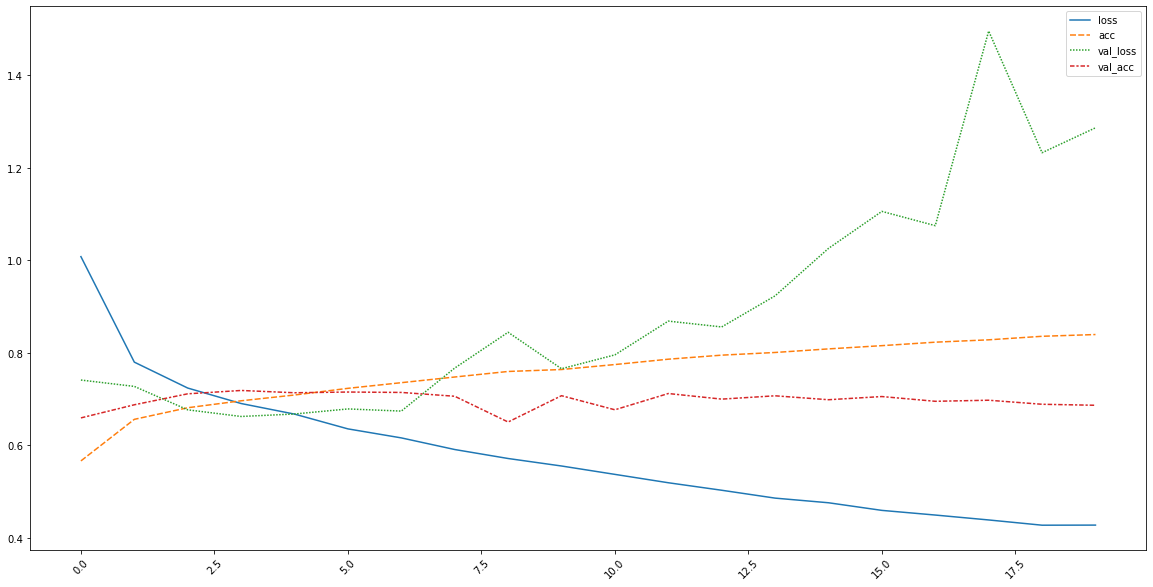

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=history_df)

### Recurrent Bidirectional Neural Network

In [18]:
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional, LSTM, GRU
from keras.models import Model, Sequential


model = Sequential()
model.add(Embedding(num_words,
                    EMBEDDING_DIM,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
model.add(Dropout(0.1))
model.add(Bidirectional(GRU(16, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(8)))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])


history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_val, y_val))

history_dict_recurrentBidirectional = history.history
acc_recurrentBidirectional = history_dict_recurrentBidirectional['acc']
vacc_recurrentBidirectional = history_dict_recurrentBidirectional['val_acc']
loss_recurrentBidirectional = history_dict_recurrentBidirectional['loss']
vloss_recurrentBidirectional = history_dict_recurrentBidirectional['val_loss']

Epoch 1/20
2179/2179 [==============================] - 93s 43ms/step - loss: 0.8948 - acc: 0.5962 - val_loss: 0.7328 - val_acc: 0.6751
Epoch 2/20
2179/2179 [==============================] - 93s 42ms/step - loss: 0.7618 - acc: 0.6698 - val_loss: 0.7105 - val_acc: 0.6867
Epoch 3/20
2179/2179 [==============================] - 93s 43ms/step - loss: 0.7212 - acc: 0.6908 - val_loss: 0.6657 - val_acc: 0.7127
Epoch 4/20
2179/2179 [==============================] - 93s 43ms/step - loss: 0.6966 - acc: 0.7029 - val_loss: 0.6598 - val_acc: 0.7150
Epoch 5/20
2179/2179 [==============================] - 93s 43ms/step - loss: 0.6763 - acc: 0.7106 - val_loss: 0.6398 - val_acc: 0.7273
Epoch 6/20
2179/2179 [==============================] - 93s 43ms/step - loss: 0.6675 - acc: 0.7166 - val_loss: 0.6315 - val_acc: 0.7304
Epoch 7/20
2179/2179 [==============================] - 95s 43ms/step - loss: 0.6553 - acc: 0.7236 - val_loss: 0.6299 - val_acc: 0.7336
Epoch 8/20
2179/2179 [==========================

<AxesSubplot:>

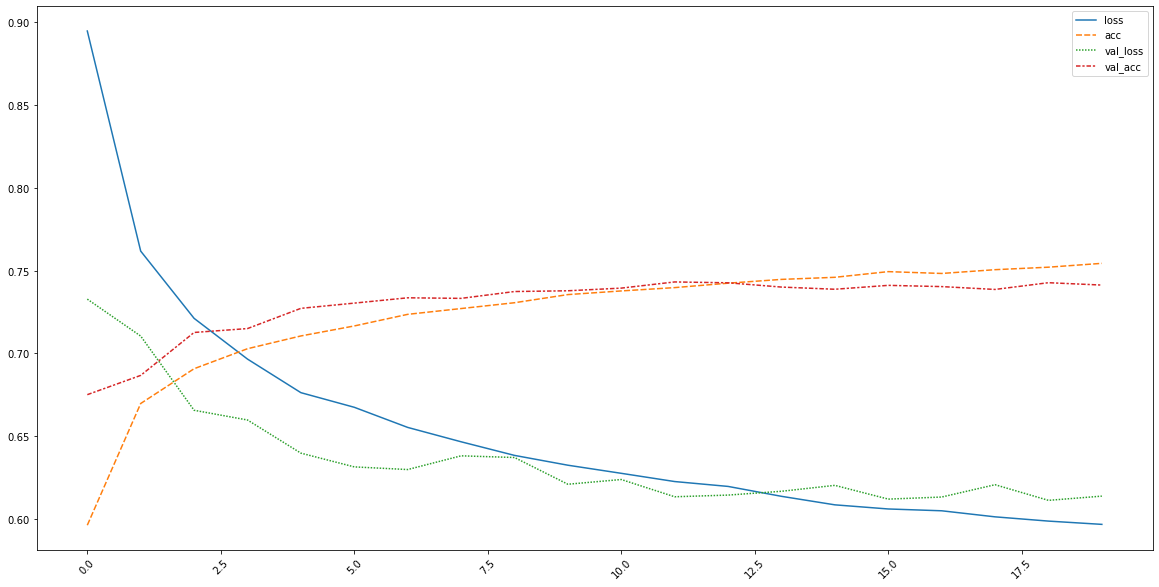

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=history_df)

# Classic Machine Learning

# Summery

## Base line

* baselines berechnen 
* Loss or Accuracy

## Comparing results

## Restriction

## Problems